# Arrow detection using tensorflow

## 1. Load configs

In [5]:
%load_ext autoreload
%autoreload 2

import os
import pickle

files = pickle.load(open('files.pickle', 'rb'))
paths = pickle.load(open('paths.pickle', 'rb'))
paths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'WORKSPACE_PATH': 'Tensorflow/workspace',
 'SCRIPTS_PATH': 'Tensorflow/scripts',
 'APIMODEL_PATH': 'Tensorflow/models',
 'ANNOTATION_PATH': 'Tensorflow/workspace/annotations',
 'IMAGE_PATH': 'Tensorflow/workspace/images',
 'MODEL_PATH': 'Tensorflow/workspace/models',
 'PRETRAINED_MODEL_PATH': 'Tensorflow/workspace/pre-trained-models',
 'CHECKPOINT_PATH': 'Tensorflow/workspace/models/my_ssd_mobnet_640',
 'OUTPUT_PATH': 'Tensorflow/workspace/models/my_ssd_mobnet_640/export',
 'TFJS_PATH': 'Tensorflow/workspace/models/my_ssd_mobnet_640/tfjsexport',
 'TFLITE_PATH': 'Tensorflow/workspace/models/my_ssd_mobnet_640/tfliteexport',
 'PROTOC_PATH': 'Tensorflow/protoc'}

## 2. Load model

In [6]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [7]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-7')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

## 3. Load image and detect

In [8]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt

from PIL import Image, ImageDraw, ImageFont
font = ImageFont.truetype('arial.ttf', 24)

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [17]:
def show_detections(detections):
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes'] + label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=10,
                min_score_thresh=.1,
                agnostic_mode=False)

    plt.figure(figsize= (10,10))
    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()

In [10]:
import glob

category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
b = glob.glob(os.path.join(paths['IMAGE_PATH'], 'test')+"/*.jpg")
IMAGE_PATH = b[1]

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

IMAGE_PATH

'Tensorflow/workspace/images/test/IMG_20210706_094801.jpg'

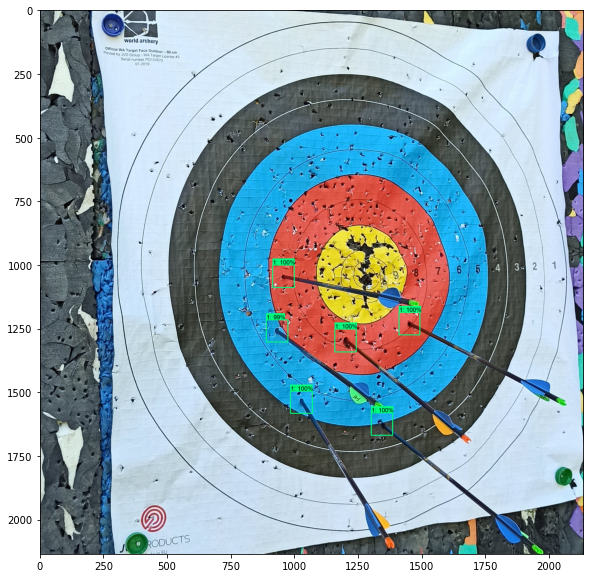

In [13]:
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

show_detections(detections)

In [67]:
detections

{'detection_boxes': <tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
 array([[[0.30382288, 0.40099356, 0.34192365, 0.4430953 ],
         [0.38598302, 0.59580827, 0.42246   , 0.6349906 ],
         [0.28036988, 0.31875557, 0.31683618, 0.36075908],
         [0.39700723, 0.47302166, 0.43352228, 0.51179177],
         [0.575068  , 0.5134866 , 0.610705  , 0.55248857],
         [0.55992055, 0.5251614 , 0.5959281 , 0.5639998 ],
         [0.        , 0.0021075 , 0.0368963 , 0.03989317],
         [0.26130903, 0.46302825, 0.2964055 , 0.50492394],
         [0.03814027, 0.        , 0.07599408, 0.03605497],
         [0.29301646, 0.5748104 , 0.32812694, 0.6154611 ],
         [0.        , 0.0597351 , 0.03739715, 0.09761754],
         [0.6765376 , 0.66135174, 0.70972043, 0.70246965],
         [0.3012087 , 0.5008519 , 0.33801678, 0.5414491 ],
         [0.27802178, 0.28481403, 0.3132914 , 0.32672563],
         [0.26443255, 0.39656878, 0.30082572, 0.43897462],
         [0.4780985 , 0.4984371 , 0.515185

## TensorFlow Lite

In [14]:
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    original_image = img
    resized_img = tf.image.resize(img, (640, 640))
    resized_img = resized_img[tf.newaxis, :]
    return resized_img, original_image

def get_output_tensor(interpreter, index):
    output_details = interpreter.get_output_details()[index]
    tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
    return tensor

def detect_objects(interpreter, image, threshold):
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], image)
    interpreter.invoke()

    scores = get_output_tensor(interpreter, 0)
    boxes = get_output_tensor(interpreter, 1)
    count = int(get_output_tensor(interpreter, 2))
    classes = get_output_tensor(interpreter, 3)
    results = []
    for i in range(count):
        if scores[i] >= threshold:
            result = {
                'bounding_box': boxes[i],
                'class_id': classes[i],
                'score': scores[i]
            }
            results.append(result)
    return results


In [19]:
import numpy as np
import tensorflow as tf
from tflite_runtime.interpreter import Interpreter

model = 'my_ssd_mobnet_640'

interpreter = Interpreter('Tensorflow/workspace/models/' + model + '/tfliteexport/saved_model/detect.tflite')
interpreter.allocate_tensors()
_, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

resized_img, original_image = preprocess_image(IMAGE_PATH)
res = detect_objects(interpreter, resized_img, 0.1)

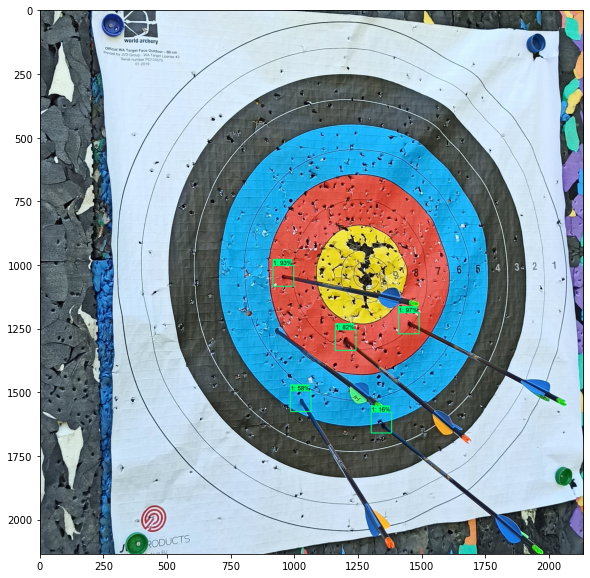

In [20]:
detections = {}
l = len(res)
detections['detection_boxes'] = tf.constant([r['bounding_box'] for r in res], shape=(1, l, 4), dtype=tf.float32)
detections['detection_classes'] = tf.constant([r['class_id'] for r in res], shape=(1, l), dtype=tf.float32)
detections['detection_scores'] = tf.constant([r['score'] for r in res], shape=(1, l), dtype=tf.float32)
detections['num_detections'] = l
show_detections(detections)